# Geonames modifications

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

## Read the CSV file into a pandas dataframe

In [2]:
header = ['geonameid','name','asciiname','alternatenames','latitude','longitude','feature class','feature code','country code','cc2','admin1 code','admin2 code','admin3 code','admin4 code','population','elevation','dem','timezone','modification date']
geonames = pd.read_csv('D:/Geonames/allCountries.txt', delimiter='\t', header=None, names=header, low_memory=False)
#geonames = pd.read_csv('D:/Geonames/cities1000.txt', delimiter='\t', header=None, names=header, low_memory=False)

## Create a simple histogram using the modification date

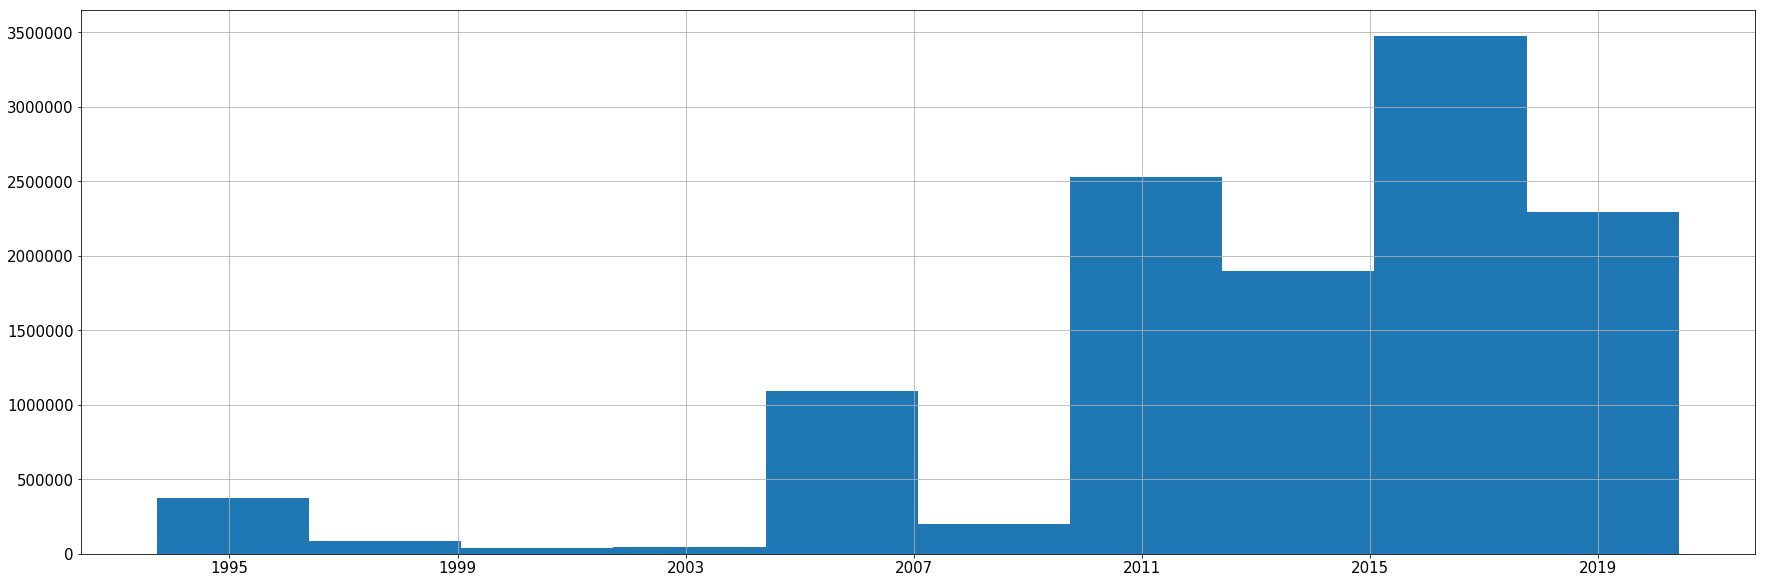

In [3]:
dates = pd.to_datetime(geonames['modification date'])
plt.rcParams['figure.figsize'] = (30, 10)
plt.rcParams.update({'font.size': 15})
dates.hist()
geonames["dates"] = dates

## Create a simple bar plot using the country code

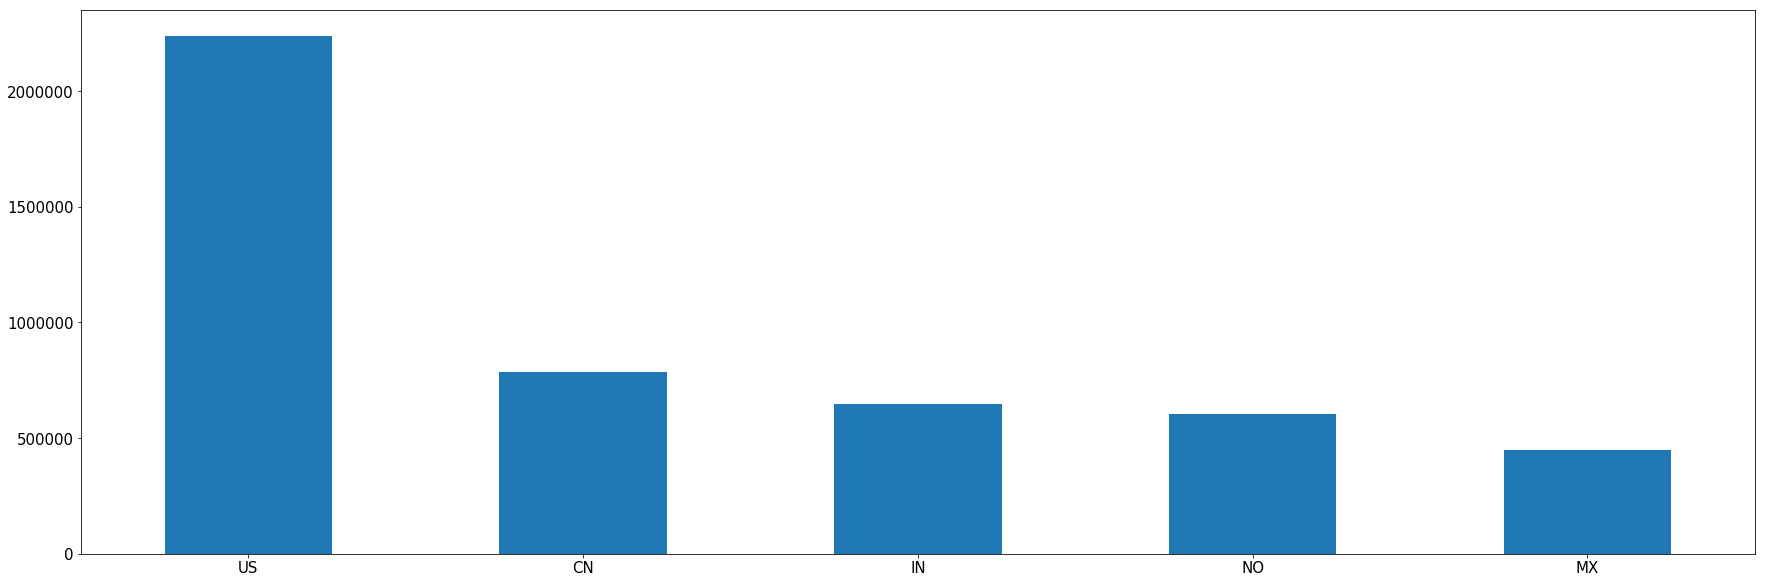

In [4]:
geonames_country_counts = pd.value_counts(geonames['country code'].values, sort=True)
geonames_country_counts.head().plot.bar(rot=0)

## Filter by month and year

In [5]:
import calendar
import datetime

def filter_month_year(geonames, year, month):
    (weekday, days) = calendar.monthrange(year, month)
    first_date = datetime.datetime(year, month, 1)
    last_date = datetime.datetime(year, month, days, 23, 59, 59)
    filter = (first_date <= geonames['dates']) & (geonames['dates'] <= last_date)
    return geonames.loc[filter]

def filter_day_month_year(geonames, year, month, day):
    filter = datetime.datetime(year, month, day) == geonames['dates']
    return geonames.loc[filter]

geonames_filtered = filter_day_month_year(geonames, 2016, 2, 1)
#geonames_filtered = filter_month_year(geonames, 2019, 2)

## Create a simple focus map

In [6]:
import arcgis
from arcgis.gis import GIS
from arcgis.features import FeatureLayer
from arcgis.features import GeoAccessor
from arcgis.features import SpatialDataFrame
from arcgis.geometry.filters import intersects

gis = GIS()
focus_map = gis.map()
focus_map.basemap = 'osm'
#focus_map

## Create a spatial data frame

In [7]:
def create_spatial_dataframe(geonames):
    geonames_copy = geonames.copy()
    return GeoAccessor.from_xy(geonames_copy, x_column="longitude", y_column="latitude", sr=4326)
    
geonames_spatial = create_spatial_dataframe(geonames_filtered)

## Create a spatial grid

In [8]:
from arcgis.features import Feature
from arcgis.features import FeatureSet
from arcgis.geometry import Envelope
from arcgis.geometry import intersect
from arcgis.geometry import Point
from arcgis.geometry import Polygon
from arcgis.geometry import project
from math import ceil, floor, isnan

def create_spatial_grid(spacing_meters):
    # Use WGS84
    envelope_wgs84 = Envelope({
        'xmin' : -180.0, 
        'ymin' : -90.0, 
        'xmax' : 180.0, 
        'ymax' : 90.0, 
        'spatialReference' : {'wkid' : 4326}
    })
    input_geometries = [envelope_wgs84]
    projected_geometries = project(input_geometries, in_sr='4326', out_sr='3857')
    envelope_mercator = projected_geometries[0]
    rows = int(ceil((envelope_mercator.ymax - envelope_mercator.ymin) / spacing_meters))
    columns = int(ceil((envelope_mercator.xmax - envelope_mercator.xmin) / spacing_meters)) - 1
    geometries = []
    for column in range(0, columns):
        for row in range(0, rows):
            recbin_mercator = Envelope({
                'xmin' : envelope_mercator.xmin + (column * spacing_meters),
                'xmax' : envelope_mercator.xmin + ((column + 1) * spacing_meters),
                'ymin' : envelope_mercator.ymin + (row * spacing_meters),
                'ymax' : envelope_mercator.ymin + ((row + 1) * spacing_meters),
                'spatialReference': {'wkid' : 3857}
            })
            if columns == column + 1:
                recbin_mercator.xmax = envelope_mercator.xmax
                
            geometries.append(recbin_mercator.polygon)
    
    return geometries

def create_spatial_hexgrid(spacing_meters):
    # Use WGS84
    envelope_wgs84 = Envelope({
        'xmin' : -180.0, 
        'ymin' : -90.0, 
        'xmax' : 180.0, 
        'ymax' : 90.0, 
        'spatialReference' : {'wkid' : 4326}
    })
    
    xvertexlo = 0.288675134594813 * spacing_meters
    xvertexhi = 0.577350269189626 * spacing_meters
    xspacing = xvertexlo + xvertexhi
    
    input_geometries = [envelope_wgs84]
    projected_geometries = project(input_geometries, in_sr='4326', out_sr='3857')
    envelope_mercator = projected_geometries[0]
    rows = int(floor((envelope_mercator.ymax - envelope_mercator.ymin) / spacing_meters))
    columns = int(floor((envelope_mercator.xmax - envelope_mercator.xmin) / xspacing))
    geometries = []
    for column in range(0, columns):
        x1 = envelope_mercator.xmin + (column * xspacing)
        x2 = x1 + (xvertexhi - xvertexlo)
        x3 = envelope_mercator.xmin + ((column + 1) * xspacing)
        x4 = x3 + (xvertexhi - xvertexlo)
        for row in range(0, rows):
            if (column % 2) == 0:
                y1 = envelope_mercator.ymin + (((row * 2)) * (0.5 * spacing_meters))
                y2 = envelope_mercator.ymin + (((row * 2) + 1) * (0.5 * spacing_meters))
                y3 = envelope_mercator.ymin + (((row * 2) + 2) * (0.5 * spacing_meters))
            else:
                y1 = envelope_mercator.ymin + (((row * 2) + 1) * (0.5 * spacing_meters))
                y2 = envelope_mercator.ymin + (((row * 2) + 2) * (0.5 * spacing_meters))
                y3 = envelope_mercator.ymin + (((row * 2) + 3) * (0.5 * spacing_meters))
            
            inner_ring = [
                [x1, y2], [x2, y1], [x3, y1], [x4, y2], [x3, y3], [x2, y3], [x1, y2]
            ]
            inner_ring.reverse()
            hexagon_mercator = Polygon({
                'rings': [inner_ring],
                'spatialReference': {'wkid' : 3857 }
            })
            geometries.append(hexagon_mercator)
    
    return geometries

def create_featureset(geometries, default_attributes):
    features = []
    object_id = 1
    object_id_field_name = 'OBJECTID'
    for geometry in geometries:
        attributes = dict(default_attributes)
        attributes[object_id_field_name] = object_id
        object_id += 1
        feature = Feature(geometry, attributes)
        features.append(feature)
    
    fields = list(attributes)
    return FeatureSet(features, fields, object_id_field_name=object_id_field_name)

def write_grid_to_geojson(grid_geometries):
    grid_featureset = create_featureset(grid_geometries, { 'hit_count' : 0 })
    with open('../data/grid.geojson', 'w') as geojson_out:
        geojson_out.write(grid_featureset.to_geojson)

# Create the grid if not existing
#recbin = create_spatial_grid(1000*500)
#write_grid_to_geojson(recbin)

#hexbin = create_spatial_hexgrid(1000*500)
#write_grid_to_geojson(hexbin)
#hexbin_featureset = create_featureset(hexbin, { 'hit_count' : 0 })
#hexbin_featureset.sdf.spatial.plot(focus_map, renderer_type='c', class_count=5, col='hit_count', cmap='Wistia', alpha=0.7)

## Create spatial binning

In [9]:
from osgeo import ogr
from osgeo import osr

def create_spatial_bins_grid(geonames_spatial, grid_geometries):
    grid_bins_features_dict = {}
    for record_index, record in geonames_spatial.iterrows():
        record_shape = record['SHAPE']
        projected_shape = project([record_shape], in_sr='4326', out_sr='3857')[0]
        intersection_geometries = intersect('3857', grid_geometries, projected_shape)
        intersection_count = len(intersection_geometries)
        for intersection_index in range(0, intersection_count):
            intersection_geometry = intersection_geometries[intersection_index]
            if not intersection_geometry.is_empty and not isnan(float(intersection_geometry.x)):
                grid_geometry = grid_geometries[intersection_index]
                if intersection_index in grid_bins_features_dict:
                    grid_feature = grid_bins_features_dict[intersection_index]
                    grid_feature.attributes['hit_count'] = grid_feature.attributes['hit_count'] + 1
                    grid_bins_features_dict[intersection_index] = grid_feature
                else:
                    grid_feature = Feature(grid_geometry, { 'hit_count': 1 })
                    grid_bins_features_dict[intersection_index] = grid_feature
                    
    grid_bins_ids = list(grid_bins_features_dict)
    grid_features = []
    for grid_bins_id in grid_bins_ids:
        grid_features.append(grid_bins_features_dict[grid_bins_id])
    
    return FeatureSet(grid_features).sdf

def create_simple_esri_polygon_from_ogr_polygon(ogr_polygon, wkid):
    inner_ring = []
    geometry_count = ogr_polygon.GetGeometryCount()
    for geometry_index in range(0, geometry_count):
        ogr_geometry = ogr_polygon.GetGeometryRef(geometry_index)
        point_count = ogr_geometry.GetPointCount()
        for point_index in range(0, point_count):
            ogr_point = ogr_geometry.GetPoint(point_index)
            inner_ring.append([ogr_point[0], ogr_point[1]])
    
    return Polygon({
        'rings': [inner_ring],
        'spatialReference': {'wkid' : wkid }
    })
        

def create_spatial_bins_offline(geonames_spatial):
    source_sr = osr.SpatialReference()
    source_sr.ImportFromEPSG(4326)

    target_sr = osr.SpatialReference()
    target_sr.ImportFromEPSG(3857)
    
    transform = osr.CoordinateTransformation(source_sr, target_sr)
    
    grid_datasource = ogr.Open('../data/grid.geojson')
    grid_layer_offline = grid_datasource.GetLayer(0)    
    grid_bins_features_dict = {}
    for record_index, record in geonames_spatial.iterrows():
        record_shape = record['SHAPE']
        record_wkt = record_shape.WKT
        record_ogr_geometry = ogr.CreateGeometryFromWkt(record_wkt)
        record_ogr_geometry.Transform(transform)
        grid_layer_offline.SetSpatialFilter(record_ogr_geometry)
        for grid_feature in grid_layer_offline:
            grid_object_id = grid_feature.GetField('OBJECTID')
            if grid_object_id in grid_bins_features_dict:
                grid_feature = grid_bins_features_dict[grid_object_id]
                grid_feature.attributes['hit_count'] = grid_feature.attributes['hit_count'] + 1
                grid_bins_features_dict[grid_object_id] = grid_feature
            else:
                ogr_grid_geometry = grid_feature.GetGeometryRef()
                grid_geometry = create_simple_esri_polygon_from_ogr_polygon(ogr_grid_geometry, 3857)
                grid_feature = Feature(grid_geometry, { 'hit_count': 1 })
                grid_bins_features_dict[grid_object_id] = grid_feature
    del grid_datasource
    
    grid_bins_ids = list(grid_bins_features_dict)
    grid_features = []
    for grid_bins_id in grid_bins_ids:
        grid_features.append(grid_bins_features_dict[grid_bins_id])
    
    return FeatureSet(grid_features).sdf
        
def create_spatial_bins(geonames_spatial):
    hex_bins_url = "https://services.arcgis.com/P3ePLMYs2RVChkJx/ArcGIS/rest/services/Global_Hex_Grid_500km/FeatureServer/0"
    hex_bins_layer = FeatureLayer(hex_bins_url)
    hex_bins_features_dict = {}
    for record_index, record in geonames_spatial.iterrows():
        record_shape = record['SHAPE']
        intersect_filter = intersects(record_shape, sr=record_shape.spatialReference)
        hex_ids_result = hex_bins_layer.query(geometry_filter=intersect_filter, return_ids_only=True)
        hex_object_ids = hex_ids_result['objectIds']
        if 0 < len(hex_object_ids):
            for hex_object_id in hex_object_ids:
                if hex_object_id in hex_bins_features_dict:
                    hex_bin_feature_entry = hex_bins_features_dict[hex_object_id]
                    hex_bin_feature_entry['hit_count'] = hex_bin_feature_entry['hit_count'] + 1
                    hex_bins_features_dict[hex_object_id] = hex_bin_feature_entry
                else:
                    hex_bins_features_dict[hex_object_id] = { 'hit_count': 1 }
        
    object_ids = list(hex_bins_features_dict)
    object_ids_filter = ",".join([str(oid) for oid in object_ids])
    hex_features_result = hex_bins_layer.query(object_ids=object_ids_filter)
    hex_spatial_dataframe = hex_features_result.sdf
    hit_counts = []
    for object_id in object_ids:
        hit_counts.append(hex_bins_features_dict[object_id]['hit_count'])
    hex_spatial_dataframe['hit_count'] = hit_counts
    return hex_spatial_dataframe

In [10]:
focus_map = gis.map()
focus_map.basemap = 'osm'

geonames_aggregated = create_spatial_bins_offline(geonames_spatial)
geonames_aggregated.spatial.plot(focus_map, renderer_type='c', class_count=5, col='hit_count', cmap='Wistia', alpha=0.7)
#geonames_spatial.spatial.plot(focus_map, alpha=0.7)

#geonames_aggregated = create_spatial_bins_grid(geonames_spatial, recbin)
#geonames_aggregated.spatial.plot(focus_map, renderer_type='c', class_count=5, col='hit_count', cmap='Wistia', alpha=0.7)
focus_map

MapView(layout=Layout(height='400px', width='100%'))

In [11]:
focus_map = gis.map()
focus_map.basemap = 'osm'
focus_map

MapView(layout=Layout(height='400px', width='100%'))

DatePicker(value=None, description='Pick a Date')

Button(description='Execute...', style=ButtonStyle())

D:/osm-geonames_2020-01-01.png
Added dataframe top rows to clipboard ...


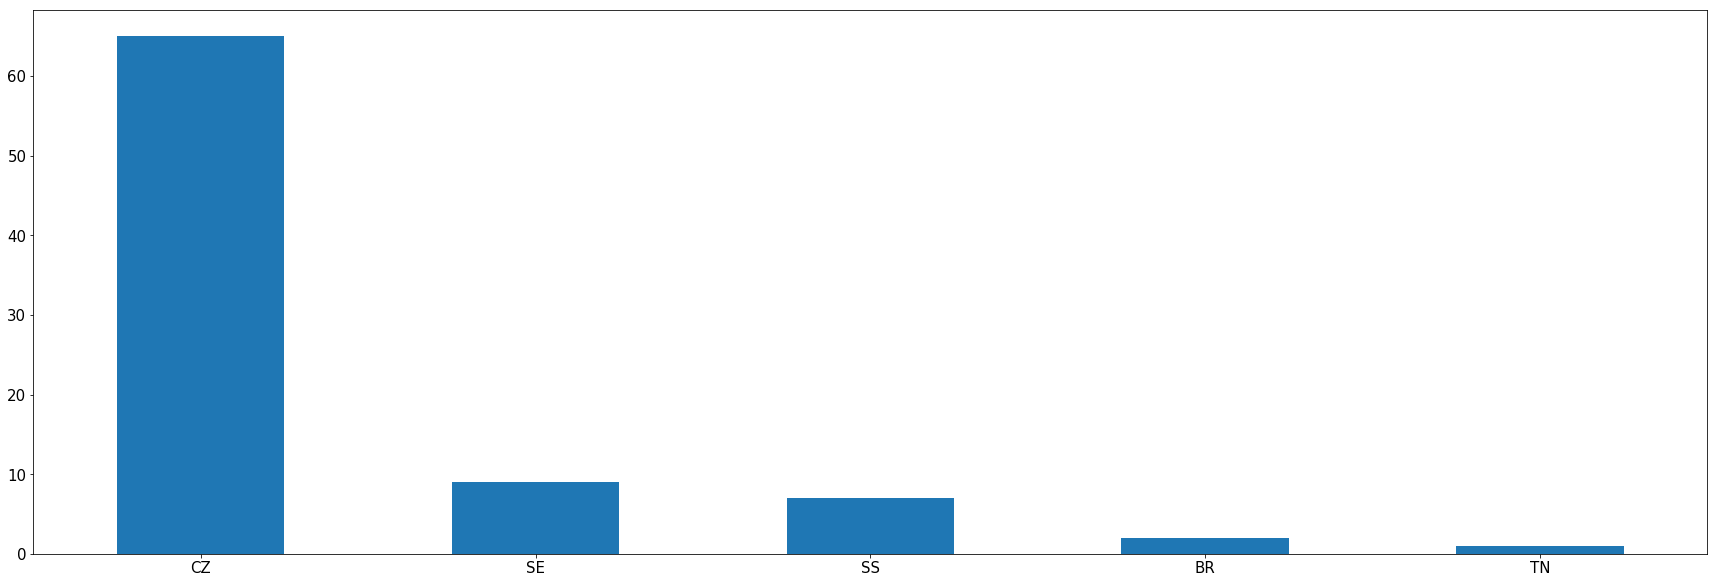

In [36]:
import ipywidgets as widgets
import time

def export_all_days(geonames, year, month):
    (weekday, days) = calendar.monthrange(year, month)
    for day in range(1, days):
        geonames_filtered = filter_day_month_year(geonames, year, month, day)
        geonames_spatial = create_spatial_dataframe(geonames_filtered)
        geonames_aggregated = create_spatial_bins_offline(geonames_spatial)
        geonames_aggregated.spatial.plot(focus_map, renderer_type='c', class_count=5, col='hit_count', cmap='Wistia', alpha=0.7)
        output_path = 'D:/osm-geonames_{}-{}-{}.png'.format(year, month, day)
        focus_map.take_screenshot(False, False, output_path)

def export_day(btn):
    filter_date = date_picker.value
    if None is filter_date:
        return
    
    geonames_filtered = filter_day_month_year(geonames, filter_date.year, filter_date.month, filter_date.day)
    geonames_spatial = create_spatial_dataframe(geonames_filtered)
    geonames_aggregated = create_spatial_bins_offline(geonames_spatial)
    geonames_aggregated.spatial.plot(focus_map, renderer_type='c', class_count=5, col='hit_count', cmap='Wistia', alpha=0.7)
    
    time.sleep(1)
    output_path = 'D:/osm-geonames_{}.png'.format(filter_date)
    focus_map.take_screenshot(False, False, output_path)
    print(output_path)
    
    geonames_country_counts = pd.value_counts(geonames_filtered['country code'].values, sort=True)
    geonames_country_counts.head().plot.bar(rot=0)
    
    geonames_filtered[['name','country code', 'timezone']].head().to_clipboard()
    print("Added dataframe top rows to clipboard ...")
    return

def export_month(btn):
    filter_date = date_picker.value
    if None is filter_date:
        return
    
    geonames_filtered = filter_month_year(geonames, filter_date.year, filter_date.month)
    geonames_spatial = create_spatial_dataframe(geonames_filtered)
    geonames_aggregated = create_spatial_bins_offline(geonames_spatial)
    geonames_aggregated.spatial.plot(focus_map, renderer_type='c', class_count=5, col='hit_count', cmap='Wistia', alpha=0.7)
    
    time.sleep(5)
    output_path = 'D:/osm-geonames_{}-{}.png'.format(filter_date.year, filter_date.month)
    focus_map.take_screenshot(False, False, output_path)
    print(output_path)
    return

date_picker = widgets.DatePicker(
    description='Pick a Date',
    disabled=False
)
display(date_picker)

btn = widgets.Button(description='Execute...')
btn.on_click(export_day)
#btn.on_click(export_month)
display(btn)

date_picker.value
#export_all_days(geonames, 2019, 1)

In [ ]:
#from IPython.display import Markdown, HTML
#display(Markdown(geonames_filtered.head().to_markdown()))